# Skin Cancer Detection

Author: Cayke Felipe dos Anjos

<img src="images/woman.webp" alt="Alt text" width="1200"/>

# Summary

In this project we analyze data from the ISIC 2024 - Skin Cancer Detection with 3D-TBP competition from Kaggle (https://www.kaggle.com/competitions/isic-2024-challenge/overview). Skin cancer is one of the most common cancers and if it is left without proper diagnosis and treatment, it can evolve fast to an irreversible condition. 

For this problem, we are given a dataset with analytical data containing patients medical data such as age and gender and also data about a skin lesion like location, radius, perimeter and color alongside with another dataset containing pictures of the lesion in order to determine if such skin lesion is benign (target=0) or malignant (target=0).

The dataset is extremely unbalanced, containing over 400 thousand data points but less than 400 malignant lesions. Because of this, we focus the metrics of our model to a partial Area Under the Curve for Receiver Operating Characteristic curve for True Positive Rate (tpr) above 0.8. A perfect score for this case would be 0.2.

We first conduct an exploratory data analysis and clean the data off features that do not help our models. We use imputation methods with the median for missing data and split it into a training set and a test set. We first analyze the analytical data with different models and methods and proceed to employ a custom Convolutional Neural Network developed by British Scientists for malignant skin lesion detection called SkinLesNet. Based on these different methodologies, we make a model recommendation to use in the future to predict if a lesion is malignant or not.

The best model is the Stochastic Gradient Descent, with an pAUC-ROC of 0.098. We propose future steps and conclude our work.

# Business Problem

Skin cancer can be deadly if not caught early, but many populations lack specialized dermatologic care. Over the past several years, dermoscopy-based AI algorithms have been shown to benefit clinicians in diagnosing melanoma, basal cell, and squamous cell carcinoma. However, determining which individuals should see a clinician in the first place has great potential impact. Triaging applications have a significant potential to benefit underserved populations and improve early skin cancer detection, the key factor in long-term patient outcomes.

Dermatoscope images reveal morphologic features not visible to the naked eye, but these images are typically only captured in dermatology clinics. Algorithms that benefit people in primary care or non-clinical settings must be adept to evaluating lower quality images. This project leverages 3D TBP (Total Body Photo) to present a novel dataset of every single lesion from thousands of patients across three continents with images resembling cell phone photos.

Our company wants to develop a tool that analyzes pictures and patient/skin lesion data obtained in clinics in hope that an AI tool can be developed to analyze pictures from the lesion taken from smartphones can be used to determine if, at least, the patient needs to be a doctor. Along with that, when examined we want to develop an algorithm that can help doctors conclude if a biopsy is necessary or not based on the patient and lesion data. A final model containing both data can also be used if it scores better than individual ones.

Questions we want to answer:
- can we use low quality pictures of the a lesion to determine if it is malignant or not?
- does data from the lesion measured in the office give us a better insight than the pcitures themselves?
- do the models perform well enough to be employed? What is the rate of false negatives and false positives for each model?

In [1]:
# We start first by importing important modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from PIL import Image,ImageOps
import glob

pd.options.display.max_columns=0

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

from score_function import pAUC_score

%matplotlib inline

2024-08-02 08:49:24.886458: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-08-02 08:49:24.886783: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Analytical data analysis

In [2]:
#We first start reading the analytical data and getting information from each feature
df_train = pd.read_csv('data/train-metadata.csv',low_memory=False)
df_train.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [3]:
df_train.describe()

,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,60.996869,42.289976,51.199529,8.539975,19.084517,1.070408,5.054760,1.368691,-8.909552,9.455766,7.538922,0.741238,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,5.631909,10.864572,12.100527,9.679312,5.357863,0.762918,2.642928,2.215871,3.463362,3.466703,2.404951,0.143857,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,28.436490,4.223007,17.702260,0.431601,10.761634,0.000000,-13.819850,-18.088106,-38.756140,2.952675,3.001138,0.027667,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,57.297630,34.303345,42.274506,4.109589,15.426205,0.574909,3.413108,0.111030,-10.675470,6.952377,5.748160,0.656627,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,61.109173,42.343770,51.425557,5.685870,17.423950,0.931402,4.643926,1.593945,-8.132223,8.699932,6.946320,0.768215,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,64.905025,50.405051,60.495607,9.119910,21.011340,1.412154,6.274246,2.850638,-6.397103,11.243486,8.748403,0.853175,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,130.983300,87.548888,98.588250,334.152700,87.205340,9.952932,32.137590,12.643930,-1.590631,39.197720,30.487456,0.974960,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [5]:
df_train['target'].value_counts()

target
0    400666
1       393
Name: count, dtype: int64

In [6]:
df_train['image_type'].value_counts()

image_type
TBP tile: close-up    401059
Name: count, dtype: int64

In [7]:
df_train['tbp_tile_type'].value_counts()

tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64

In [8]:
df_train[df_train['tbp_tile_type']=='3D: XP']['target'].value_counts()

target
0    285706
1       197
Name: count, dtype: int64

In [9]:
df_train[df_train['tbp_tile_type']=='3D: white']['target'].value_counts()

target
0    114960
1       196
Name: count, dtype: int64

The dataset is extremely unbalanced and contain several columns with no important information to our models or analyzes.

We start by dropping columns that do not contain information that will add information to our model or that are only present in the training data.

In [10]:
df_train_dropped = df_train.drop(['patient_id','image_type','lesion_id','iddx_full','iddx_1','iddx_2','iddx_3','iddx_4','iddx_5','mel_mitotic_index','mel_thick_mm','tbp_lv_dnn_lesion_confidence','attribution','copyright_license'],axis=1)
df_train_dropped.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,ISIC_0015670,0,60.0,male,lower extremity,3.04,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,ISIC_0015845,0,60.0,male,head/neck,1.10,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,ISIC_0015864,0,60.0,male,posterior torso,3.40,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,ISIC_0015902,0,65.0,male,anterior torso,3.22,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,ISIC_0024200,0,55.0,male,anterior torso,2.73,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


Then we analyze how different features distribute the target class.

In [11]:
df_train_dropped[df_train_dropped['target']==0]['anatom_site_general'].value_counts(),df_train_dropped[df_train_dropped['target']==1]['anatom_site_general'].value_counts()

(anatom_site_general
 posterior torso    121799
 lower extremity    102955
 anterior torso      87688
 upper extremity     70500
 head/neck           11968
 Name: count, dtype: int64,
 anatom_site_general
 posterior torso    103
 anterior torso      82
 head/neck           78
 lower extremity     73
 upper extremity     57
 Name: count, dtype: int64)

In [12]:
df_train_dropped[df_train_dropped['target']==0]['tbp_lv_location'].value_counts(),df_train_dropped[df_train_dropped['target']==1]['tbp_lv_location'].value_counts()

(tbp_lv_location
 Torso Back Top Third       71045
 Torso Front Top Half       63281
 Torso Back Middle Third    46153
 Left Leg - Lower           27404
 Right Leg - Lower          25184
 Torso Front Bottom Half    24347
 Left Leg - Upper           23659
 Right Leg - Upper          23030
 Right Arm - Upper          22954
 Left Arm - Upper           22796
 Head & Neck                11968
 Left Arm - Lower           11927
 Right Arm - Lower          10631
 Unknown                     5756
 Torso Back Bottom Third     4592
 Left Leg                    1968
 Right Leg                   1710
 Left Arm                    1591
 Right Arm                    601
 Torso Front                   60
 Torso Back                     9
 Name: count, dtype: int64,
 tbp_lv_location
 Head & Neck                78
 Torso Front Top Half       69
 Torso Back Top Third       67
 Torso Back Middle Third    32
 Right Leg - Lower          24
 Left Leg - Lower           24
 Left Arm - Upper           20
 Right 

In [13]:
df_train_dropped[df_train_dropped['target']==0]['tbp_lv_location_simple'].value_counts(),df_train_dropped[df_train_dropped['target']==1]['tbp_lv_location_simple'].value_counts()

(tbp_lv_location_simple
 Torso Back     121799
 Torso Front     87688
 Left Leg        53031
 Right Leg       49924
 Left Arm        36314
 Right Arm       34186
 Head & Neck     11968
 Unknown          5756
 Name: count, dtype: int64,
 tbp_lv_location_simple
 Torso Back     103
 Torso Front     82
 Head & Neck     78
 Left Leg        44
 Left Arm        34
 Right Leg       29
 Right Arm       23
 Name: count, dtype: int64)

Some of these columns have the same information, only more detailed. We do not need to distinguish between a lesion being on the right or left leg so we also drop the two lost columns.

In [14]:
df_train_dropped.drop(['tbp_lv_location','tbp_lv_location_simple'],axis=1,inplace=True)
df_train_dropped.head()

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,ISIC_0015670,0,60.0,male,lower extremity,3.04,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948
1,ISIC_0015845,0,60.0,male,head/neck,1.10,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500
2,ISIC_0015864,0,60.0,male,posterior torso,3.40,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900
3,ISIC_0015902,0,65.0,male,anterior torso,3.22,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802
4,ISIC_0024200,0,55.0,male,anterior torso,2.73,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960


In [15]:
df_train_dropped[df_train_dropped['anatom_site_general'].isna()]['target'].value_counts()

target
0    5756
Name: count, dtype: int64

In [16]:
df_train_dropped[df_train_dropped['age_approx'].isna()]['target'].value_counts()

target
0    2795
1       3
Name: count, dtype: int64

In [17]:
df_train_dropped[df_train_dropped['sex'].isna()]['target'].value_counts()

target
0    11507
1       10
Name: count, dtype: int64

Age and sex will need imputing since we cannot just delete data with target=1. Anatomic site general on the other hand, only has missing values on target=0 so we can drop those entries.

In [18]:
#We can safely drop all the Unknown values from this column
df_train_dropped = df_train_dropped[~df_train_dropped['anatom_site_general'].isna()]

In [19]:
df_train_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395303 entries, 0 to 401058
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   isic_id                      395303 non-null  object 
 1   target                       395303 non-null  int64  
 2   age_approx                   392520 non-null  float64
 3   sex                          383794 non-null  object 
 4   anatom_site_general          395303 non-null  object 
 5   clin_size_long_diam_mm       395303 non-null  float64
 6   tbp_tile_type                395303 non-null  object 
 7   tbp_lv_A                     395303 non-null  float64
 8   tbp_lv_Aext                  395303 non-null  float64
 9   tbp_lv_B                     395303 non-null  float64
 10  tbp_lv_Bext                  395303 non-null  float64
 11  tbp_lv_C                     395303 non-null  float64
 12  tbp_lv_Cext                  395303 non-null  float64
 13  tbp_

In [20]:
#Changing value of genders and renaming column
df_train_dropped['sex'].replace({'male':1,'female':0},inplace=True)
df_train_dropped.rename(columns={'sex':'male'},inplace=True)

We use OneHotEncoder to create nominal features based on the location of the lesion.

In [21]:
ohe = OneHotEncoder(drop='first',sparse_output=False)

In [22]:
nomX = ohe.fit_transform(df_train_dropped[['anatom_site_general']])

In [23]:
ohe.categories_

[array(['anterior torso', 'head/neck', 'lower extremity',
        'posterior torso', 'upper extremity'], dtype=object)]

In [25]:
nomX = pd.DataFrame(nomX, columns=ohe.get_feature_names_out(),index = df_train_dropped.index)
nomX


,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
401054,0.0,0.0,0.0,0.0
401055,0.0,0.0,1.0,0.0
401056,0.0,0.0,0.0,0.0
401057,0.0,0.0,0.0,0.0


In [27]:
df_train_final = pd.concat([df_train_dropped.drop(['anatom_site_general'],axis=1),nomX],axis=1)
df_train_final

,isic_id,target,age_approx,male,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity
0,ISIC_0015670,0,60.0,1.0,3.04,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.000000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.000000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,0.0,1.0,0.0,0.0
1,ISIC_0015845,0,60.0,1.0,1.10,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.000000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,1.0,0.0,0.0,0.0
2,ISIC_0015864,0,60.0,1.0,3.40,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.000000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.000000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,0.0,0.0,1.0,0.0
3,ISIC_0015902,0,65.0,1.0,3.22,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.514520,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.664690,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,0.0,0.0,0.0,0.0
4,ISIC_0024200,0,55.0,1.0,2.73,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.000000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.000000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,70.0,1.0,6.80,3D: XP,22.574335,14.944666,27.663259,26.767135,35.705132,30.656525,50.784168,60.824438,36.333547,53.341997,22.893601,17.842449,2.579861,7.629668,0.896124,-17.008450,17.187750,13.498163,0.744495,4.877998,9.936233e+01,3.101811,7.348126,20.210836,2.328066,7.054819,2.169398,0.288920,100,147.187256,1182.317505,122.652588,0.0,0.0,0.0,0.0
401055,ISIC_9999951,0,60.0,1.0,3.11,3D: white,19.977640,16.026870,34.158840,31.011870,39.571870,34.908400,59.678970,62.670170,59.102310,67.064370,4.785138,18.231470,0.812333,3.950773,3.146977,-7.962059,8.671249,5.681591,0.719667,2.157864,2.311562e-01,4.439972,2.795246,9.340242,1.048147,1.879502,2.910780,0.460000,25,52.349740,1393.187000,127.261700,0.0,0.0,1.0,0.0
401056,ISIC_9999960,0,65.0,0.0,2.05,3D: XP,17.332567,12.364397,29.845326,26.500073,34.513206,29.242644,59.854275,64.987196,39.413663,47.840501,2.758491,13.050010,0.498197,4.968169,3.345253,-8.426838,9.267366,7.842607,0.649815,1.595713,5.994798e+01,1.444499,1.660411,5.999862,0.607554,1.702824,2.205272,0.183099,40,54.622246,1065.263672,-106.833740,0.0,0.0,0.0,0.0
401057,ISIC_9999964,0,30.0,0.0,2.80,3D: XP,22.288570,9.564721,28.431200,27.012250,36.126360,28.655640,51.905420,70.501540,49.328490,60.874160,6.023644,13.787630,1.317875,12.723850,1.418951,-11.545660,11.751160,8.515440,0.492929,2.5479

Because of the size of our dataset, we need to sample part of it to run our models fast.

In [28]:
df_train_final_part = df_train_final.sample(frac=0.1,random_state=10)
df_train_final_part

,isic_id,target,age_approx,male,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity
217766,ISIC_5472703,0,60.0,0.0,2.70,3D: white,22.942980,18.606150,25.15006,25.377220,34.042710,31.467320,47.627570,53.751760,43.54005,57.759830,4.147120,13.743930,1.087487,4.336829,-0.227156,-14.219780,14.610700,10.494880,0.735012,1.837864,60.327630,1.669712,3.268771,7.549685,1.093460,4.644154,1.751736,0.196429,30,-71.303960,1339.664000,32.026310,0.0,0.0,0.0,0.0
159621,ISIC_4030401,0,80.0,1.0,6.68,3D: XP,15.387620,11.985790,21.35918,18.924520,26.324770,22.400810,54.230190,57.651990,25.45066,30.366350,17.113910,22.224250,1.776464,3.401834,2.434660,-4.915685,5.683892,6.415445,0.748848,4.066204,93.965200,4.634396,5.619682,19.502400,1.969442,2.134899,2.938792,0.388007,160,68.122430,1439.684000,-58.349850,0.0,0.0,0.0,0.0
379937,ISIC_9472581,0,50.0,1.0,3.68,3D: XP,21.055270,15.405300,28.51691,25.517630,35.447680,29.807260,53.559940,58.880120,41.35679,49.340910,8.463126,20.928970,1.498776,5.649966,2.999273,-7.984123,8.975325,7.141361,0.588290,2.905918,34.236900,3.902221,4.458732,13.308810,1.476715,2.352392,2.709585,0.321033,75,109.774100,1374.660000,-39.891910,0.0,0.0,0.0,0.0
164144,ISIC_4143749,0,55.0,0.0,3.45,3D: XP,18.002980,12.365780,34.91656,31.893230,39.284520,34.206580,62.724370,68.807480,49.30439,57.496030,5.704635,15.822900,1.366589,5.637205,3.023337,-8.191640,8.820971,6.607239,0.826412,2.038236,65.710300,2.036591,4.292012,9.500731,1.494711,2.657527,1.739133,0.194805,90,-29.444090,859.704800,-129.264300,0.0,0.0,0.0,0.0
187828,ISIC_4731212,0,25.0,0.0,5.03,3D: XP,20.821088,11.723158,30.69276,28.621945,37.088586,30.929729,55.848157,67.726664,46.27710,60.492555,10.921374,16.332917,1.497884,9.097930,2.070815,-14.215455,14.446487,10.511325,0.813124,2.909539,99.238330,1.811717,4.073011,13.355818,1.225156,4.964450,1.833732,0.151899,120,143.506348,858.130615,-35.024567,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62231,ISIC_1608744,0,40.0,0.0,3.60,3D: white,19.197130,15.293380,30.36750,28.428190,35.926510,32.280790,57.700550,61.721290,62.43167,69.681750,4.710077,23.480340,0.619187,3.903751,1.939307,-7.250075,7.582331,4.855455,0.919303,1.842423,0.000043,4.853396,1.233391,10.516380,0.211780,1.500634,1.855097,0.386667,160,47.087280,1101.398000,209.885700,0.0,0.0,1.0,0.0
147752,ISIC_3741243,0,55.0,1.0,2.80,3D: XP,26.305620,18.462920,38.54941,36.066320,46.669510,40.517390,55.690880,62.891380,44.41610,57.871180,5.441922,13.735220,1.041367,7.842707,2.483090,-13.455080,13.774380,10.062800,0.444202,2.432204,95.380850,1.216680,2.565282,8.645575,0.677442,4.575311,2.333227,0.135484,80,-28.800220,1175.891000,-125.265100,0.0,0.0,0.0,0.0
154578,ISIC_3906946,0,50.0,1.0,6.20,3D: XP,19.031810,8.421490,31.93254,29.448070,37.173870,30.628580,59.205040,74.040650,45.15321,63.671580,19.290670,15.643070,4.151441,10.610320,2.484474,-18.518360,18.945190,13.225580,0.758803,4.044597,99.838730,1.812955,9.274663,17.371390,2.797340,9.422362,2.007687,0.169039,55,-132.497300,1342.190000,152.345100,0.0,0.0,1.0,0.0
232207,ISIC_5836424,0,70.0,1.0,4.66,3D: XP,17.950300,16.874840,25.96285,25.882590,31.563950,30.897710,55.340640,56.896590,32.12918,37.081520,8.106587,22.379590,0.642920,1.075455,0.080265,-4.952335,5.321346,4.952986,0.853377,2.608142,0.0089

We split the dataset into three: X, y and a vector containing important id information for each point.

In [29]:
ID_tile_type = df_train_final_part[['isic_id','tbp_tile_type']]
X = df_train_final_part.drop(['isic_id','target','tbp_tile_type'],axis=1)
y = df_train_final_part['target']

In [30]:
X

,age_approx,male,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,anatom_site_general_head/neck,anatom_site_general_lower extremity,anatom_site_general_posterior torso,anatom_site_general_upper extremity
217766,60.0,0.0,2.70,22.942980,18.606150,25.15006,25.377220,34.042710,31.467320,47.627570,53.751760,43.54005,57.759830,4.147120,13.743930,1.087487,4.336829,-0.227156,-14.219780,14.610700,10.494880,0.735012,1.837864,60.327630,1.669712,3.268771,7.549685,1.093460,4.644154,1.751736,0.196429,30,-71.303960,1339.664000,32.026310,0.0,0.0,0.0,0.0
159621,80.0,1.0,6.68,15.387620,11.985790,21.35918,18.924520,26.324770,22.400810,54.230190,57.651990,25.45066,30.366350,17.113910,22.224250,1.776464,3.401834,2.434660,-4.915685,5.683892,6.415445,0.748848,4.066204,93.965200,4.634396,5.619682,19.502400,1.969442,2.134899,2.938792,0.388007,160,68.122430,1439.684000,-58.349850,0.0,0.0,0.0,0.0
379937,50.0,1.0,3.68,21.055270,15.405300,28.51691,25.517630,35.447680,29.807260,53.559940,58.880120,41.35679,49.340910,8.463126,20.928970,1.498776,5.649966,2.999273,-7.984123,8.975325,7.141361,0.588290,2.905918,34.236900,3.902221,4.458732,13.308810,1.476715,2.352392,2.709585,0.321033,75,109.774100,1374.660000,-39.891910,0.0,0.0,0.0,0.0
164144,55.0,0.0,3.45,18.002980,12.365780,34.91656,31.893230,39.284520,34.206580,62.724370,68.807480,49.30439,57.496030,5.704635,15.822900,1.366589,5.637205,3.023337,-8.191640,8.820971,6.607239,0.826412,2.038236,65.710300,2.036591,4.292012,9.500731,1.494711,2.657527,1.739133,0.194805,90,-29.444090,859.704800,-129.264300,0.0,0.0,0.0,0.0
187828,25.0,0.0,5.03,20.821088,11.723158,30.69276,28.621945,37.088586,30.929729,55.848157,67.726664,46.27710,60.492555,10.921374,16.332917,1.497884,9.097930,2.070815,-14.215455,14.446487,10.511325,0.813124,2.909539,99.238330,1.811717,4.073011,13.355818,1.225156,4.964450,1.833732,0.151899,120,143.506348,858.130615,-35.024567,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62231,40.0,0.0,3.60,19.197130,15.293380,30.36750,28.428190,35.926510,32.280790,57.700550,61.721290,62.43167,69.681750,4.710077,23.480340,0.619187,3.903751,1.939307,-7.250075,7.582331,4.855455,0.919303,1.842423,0.000043,4.853396,1.233391,10.516380,0.211780,1.500634,1.855097,0.386667,160,47.087280,1101.398000,209.885700,0.0,0.0,1.0,0.0
147752,55.0,1.0,2.80,26.305620,18.462920,38.54941,36.066320,46.669510,40.517390,55.690880,62.891380,44.41610,57.871180,5.441922,13.735220,1.041367,7.842707,2.483090,-13.455080,13.774380,10.062800,0.444202,2.432204,95.380850,1.216680,2.565282,8.645575,0.677442,4.575311,2.333227,0.135484,80,-28.800220,1175.891000,-125.265100,0.0,0.0,0.0,0.0
154578,50.0,1.0,6.20,19.031810,8.421490,31.93254,29.448070,37.173870,30.628580,59.205040,74.040650,45.15321,63.671580,19.290670,15.643070,4.151441,10.610320,2.484474,-18.518360,18.945190,13.225580,0.758803,4.044597,99.838730,1.812955,9.274663,17.371390,2.797340,9.422362,2.007687,0.169039,55,-132.497300,1342.190000,152.345100,0.0,0.0,1.0,0.0
232207,70.0,1.0,4.66,17.950300,16.874840,25.96285,25.882590,31.563950,30.897710,55.340640,56.896590,32.12918,37.081520,8.106587,22.379590,0.642920,1.075455,0.080265,-4.952335,5.321346,4.952986,0.853377,2.608142,0.008974,5.258222,2.006269,13.469300,0.694732,1.251147,2.182619,0.468402,65,59.139470,1560.843000,-18.938350,1.0,0.0,0.0,0.0


We divide X and y sets into train and test.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=19)

In [32]:
X_train = pd.DataFrame(X_train,columns=X.columns)
X_test = pd.DataFrame(X_test,columns=X.columns)

After dividing each set we can use imputation without data leakage.

In [33]:
#The two other columns contain a large percentage of target variables (and just deleting them would not be wise. 
#Instead we use an Imputer to come up with an entry
imputer = SimpleImputer(strategy='median')

In [34]:
X_train_imputed = imputer.fit_transform(X_train[['age_approx','male']])
X_test_imputed = imputer.transform(X_test[['age_approx','male']])

In [35]:
X_train_imputed = pd.DataFrame(data=X_train_imputed,columns=['age_approx','male'],index=X_train.index)
X_test_imputed = pd.DataFrame(data=X_test_imputed,columns=['age_approx','male'],index=X_test.index)

In [36]:
X_train['age_approx'] = X_train_imputed['age_approx']
X_train['male'] = X_train_imputed['male']
X_train.isna().sum()

age_approx                             0
male                                   0
clin_size_long_diam_mm                 0
tbp_lv_A                               0
tbp_lv_Aext                            0
tbp_lv_B                               0
tbp_lv_Bext                            0
tbp_lv_C                               0
tbp_lv_Cext                            0
tbp_lv_H                               0
tbp_lv_Hext                            0
tbp_lv_L                               0
tbp_lv_Lext                            0
tbp_lv_areaMM2                         0
tbp_lv_area_perim_ratio                0
tbp_lv_color_std_mean                  0
tbp_lv_deltaA                          0
tbp_lv_deltaB                          0
tbp_lv_deltaL                          0
tbp_lv_deltaLB                         0
tbp_lv_deltaLBnorm                     0
tbp_lv_eccentricity                    0
tbp_lv_minorAxisMM                     0
tbp_lv_nevi_confidence                 0
tbp_lv_norm_bord

In [37]:
X_test['age_approx'] = X_test_imputed['age_approx']
X_test['male'] = X_test_imputed['male']
X_test.isna().sum()

age_approx                             0
male                                   0
clin_size_long_diam_mm                 0
tbp_lv_A                               0
tbp_lv_Aext                            0
tbp_lv_B                               0
tbp_lv_Bext                            0
tbp_lv_C                               0
tbp_lv_Cext                            0
tbp_lv_H                               0
tbp_lv_Hext                            0
tbp_lv_L                               0
tbp_lv_Lext                            0
tbp_lv_areaMM2                         0
tbp_lv_area_perim_ratio                0
tbp_lv_color_std_mean                  0
tbp_lv_deltaA                          0
tbp_lv_deltaB                          0
tbp_lv_deltaL                          0
tbp_lv_deltaLB                         0
tbp_lv_deltaLBnorm                     0
tbp_lv_eccentricity                    0
tbp_lv_minorAxisMM                     0
tbp_lv_nevi_confidence                 0
tbp_lv_norm_bord

In [38]:
len(X_train),len(X_test)

(29647, 9883)

Finally, we check the correlation map to see feature importance.

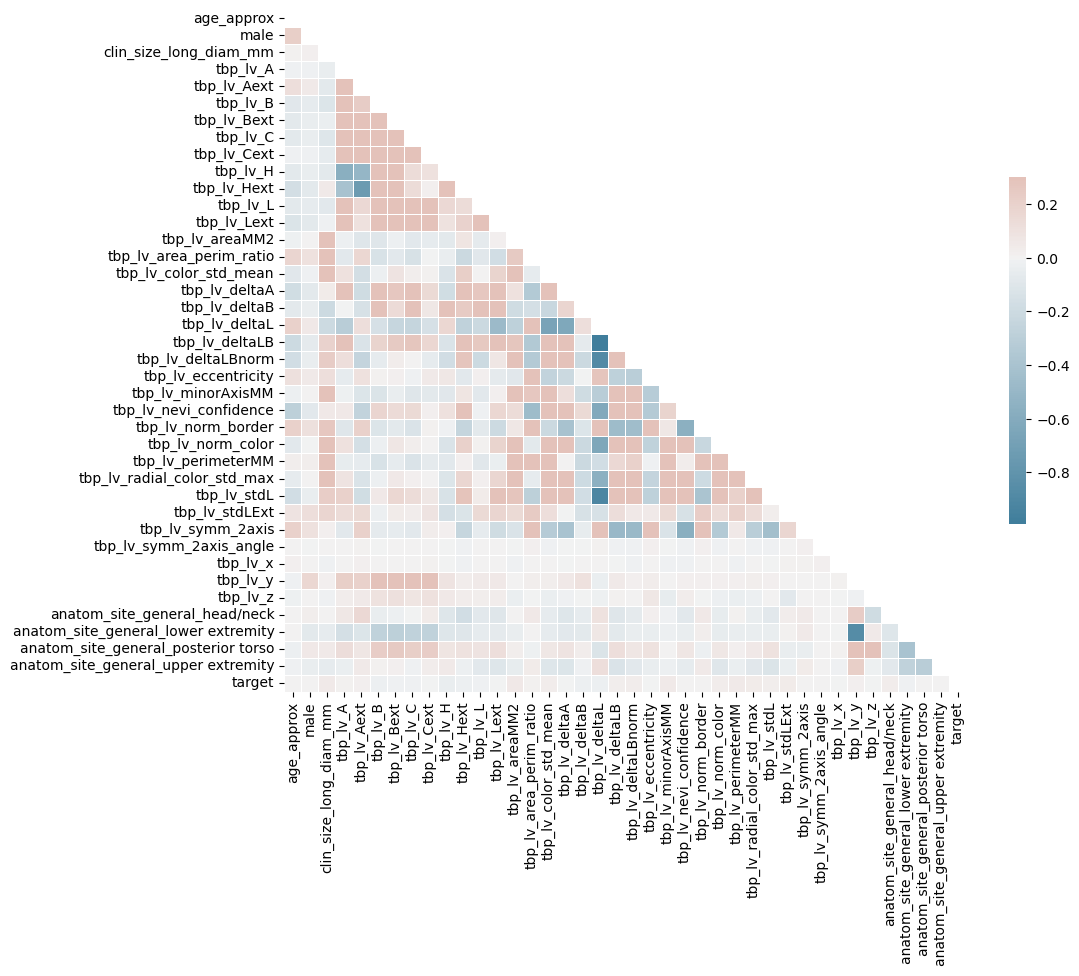

In [39]:
corr = pd.concat([X_train,y_train],axis=1).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Features do not seem to be very important for our method

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Next we use different models to see how they score with our data.

# Baseline model - Dummy Classifier

Our baseline model is a dummy classifier. This is important as this classifier will define our ROC curve with AUC=0.5

In [41]:
dc= DummyClassifier(strategy='most_frequent')

In [42]:
dc.fit(X_train_scaled,y_train)

DummyClassifier(strategy='most_frequent')

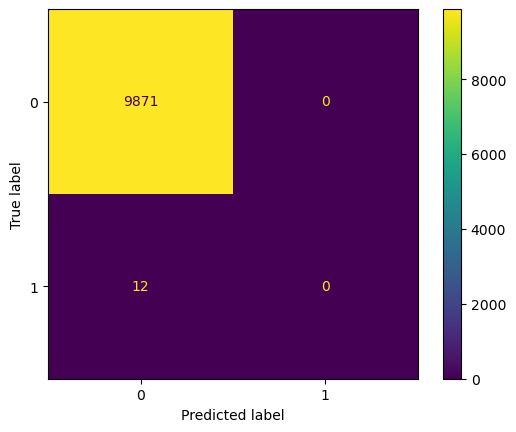

In [43]:
ConfusionMatrixDisplay.from_estimator(dc,X_test_scaled,y_test)

In [44]:
model_candidates = [
    {
        'name':'Dummy Model'
        ,'model':dc
        ,'X_test':X_test_scaled
        ,'y_test':y_test
    }]

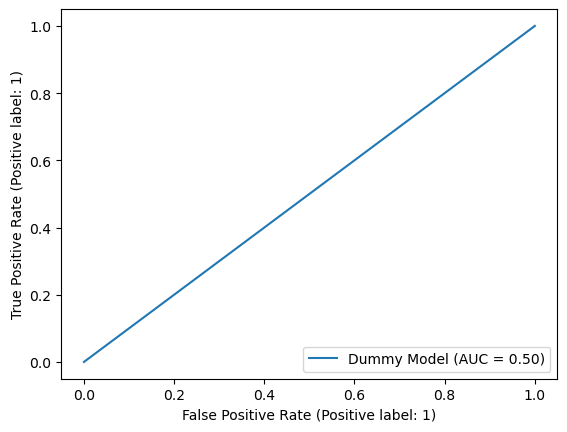

In [45]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [46]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test
y_df_test

y_df_dummy_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_dummy_pred['target'] = dc.predict(X_test_scaled)


In [47]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_dummy_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.01999999999999999


# First model - Logistic Regression

Our first model is a simple logistic regression with no penalty. Before adding to our models we should start with a basic version of it to make sure that regularization is helping.

In [48]:
logreg = LogisticRegression(penalty=None, class_weight='balanced',random_state=19, max_iter=10000)

In [49]:
logreg.fit(X_train_scaled,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=19)

In [50]:
y_logreg_pred = logreg.predict(X_test_scaled)

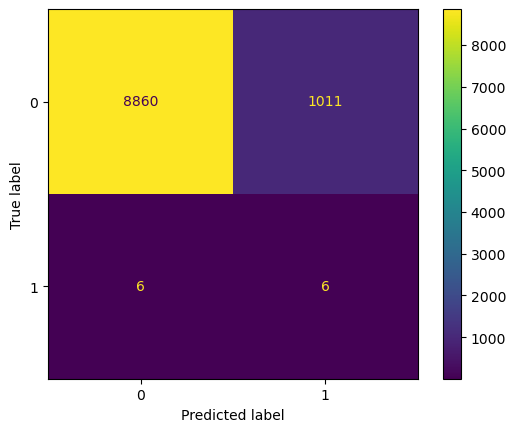

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test,y_logreg_pred)

In [52]:
print(f'Accuracy = {accuracy_score(y_test,y_logreg_pred)} Recall = {recall_score(y_test,y_logreg_pred)} Precision = {precision_score(y_test,y_logreg_pred)} F1 Score = {f1_score(y_test,y_logreg_pred)}')

Accuracy = 0.8970960234746534 Recall = 0.5 Precision = 0.0058997050147492625 F1 Score = 0.011661807580174927


In [53]:
model_candidates.append(
    {
        'name':'Logistic Regression'
        ,'model':logreg
        ,'X_test':X_test_scaled
        ,'y_test':y_test
    })

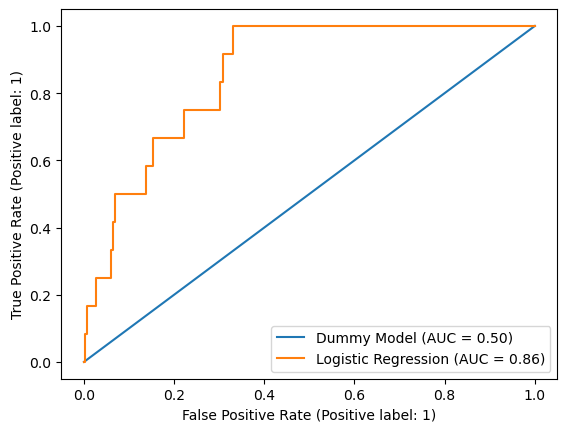

In [54]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [55]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test

y_df_logreg_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_logreg_pred['target'] = y_logreg_pred
y_df_logreg_pred

,isic_id,target
301942,ISIC_7551855,1
352194,ISIC_8794933,0
342922,ISIC_8566639,0
331403,ISIC_8284743,1
126724,ISIC_3212785,0
...,...,...
190586,ISIC_4798399,0
203127,ISIC_5111203,0
341897,ISIC_8542800,0
246276,ISIC_6187644,0


In [56]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_logreg_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.035903150643298534


# Second Model - Decision Trees

Our second model is a decision tree. We have also tried using Random Forests but our models failed to find any True Positives and had a large amount of False Positives.

In [57]:
dtc = DecisionTreeClassifier(random_state=19,class_weight='balanced')

In [58]:
dtc.fit(X_train_scaled,y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=19)

In [59]:
y_dtc_pred = dtc.predict(X_test_scaled)

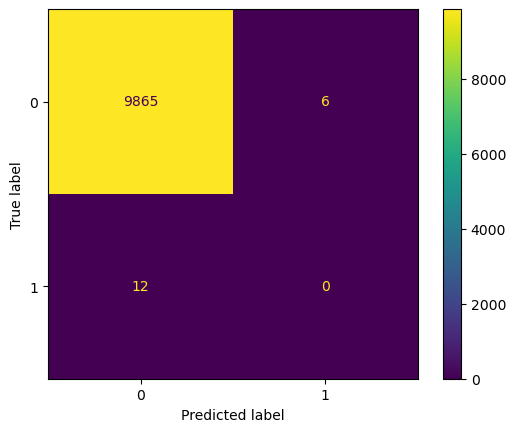

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test,y_dtc_pred)

In [61]:
print(f'Accuracy = {accuracy_score(y_test,y_dtc_pred)} Recall = {recall_score(y_test,y_dtc_pred)} Precision = {precision_score(y_test,y_dtc_pred)} F1 Score = {f1_score(y_test,y_dtc_pred)}')

Accuracy = 0.9981786906809673 Recall = 0.0 Precision = 0.0 F1 Score = 0.0


In [62]:
model_candidates.append(
    {
        'name':'Decision Tree'
        ,'model':dtc
        ,'X_test':X_test_scaled
        ,'y_test':y_test
    })

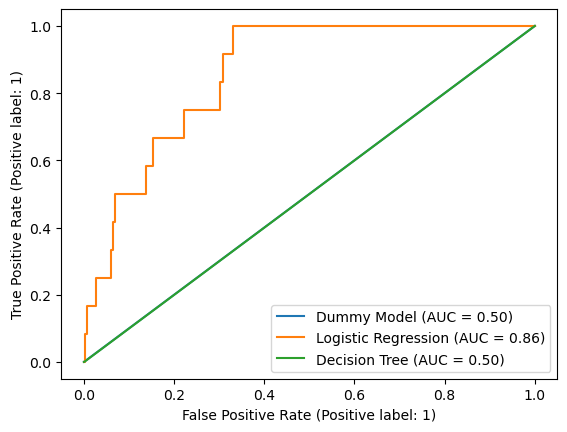

In [63]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [64]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test


y_df_dtc_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_dtc_pred['target'] = y_dtc_pred


In [65]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_dtc_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.019987843176983072


# Third Model - Stochastic Gradient Classifier

Because of the size of our data, a smart approach would be using a stochastic gradient descent as it is much faster to calculate gradients and reach a good answer (which might not be optimal).

In [66]:
sgd = SGDClassifier(penalty=None, random_state=19, class_weight='balanced', max_iter=10000)

In [67]:
sgd.fit(X_train_scaled,y_train)

/home/cayke/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(class_weight='balanced', max_iter=10000, penalty=None,
              random_state=19)

In [68]:
sgd.score

<bound method ClassifierMixin.score of SGDClassifier(class_weight='balanced', max_iter=10000, penalty=None,
              random_state=19)>

In [69]:
y_sgd_pred = sgd.predict(X_test_scaled)

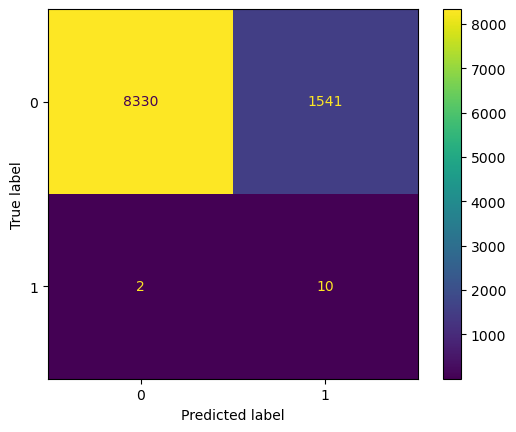

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test,y_sgd_pred)

In [71]:
print(f'Accuracy = {accuracy_score(y_test,y_sgd_pred)} Recall = {recall_score(y_test,y_sgd_pred)} Precision = {precision_score(y_test,y_sgd_pred)} F1 Score = {f1_score(y_test,y_sgd_pred)}')

Accuracy = 0.8438733178184762 Recall = 0.8333333333333334 Precision = 0.006447453255963894 F1 Score = 0.012795905310300703


In [72]:
model_candidates.append(
    {
        'name':'Stochastic Gradient Descent'
        ,'model':sgd
        ,'X_test':X_test_scaled
        ,'y_test':y_test
    })

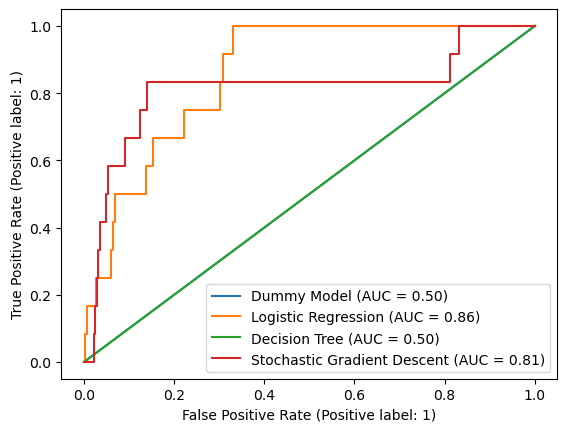

In [73]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [74]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test


y_df_sgd_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_sgd_pred['target'] = y_sgd_pred


In [75]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_sgd_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.09855745787323132


We now start using regularization methods along with polynomial features to check if they make our answer better.

# Fourth Model -  Logistic Regression with L2 Penalty

In [76]:
logreg_pen = LogisticRegression(solver='liblinear',random_state=19,class_weight='balanced',max_iter=10000)
pf = PolynomialFeatures(degree=2)

In [77]:
X_train_scaled_poly = pf.fit_transform(X_train_scaled)
X_test_scaled_poly = pf.transform(X_test_scaled)

In [78]:
param = [{'penalty':['l2'], 
          'C':[0.001,0.1,1,10,100]}]

In [79]:
grid_logreg_pen = GridSearchCV(logreg_pen,param_grid=param,scoring='recall',verbose=3,cv=2)

In [80]:
grid_logreg_pen.fit(X_train_scaled_poly,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END ...............C=0.001, penalty=l2;, score=0.167 total time=   4.1s
[CV 2/2] END ...............C=0.001, penalty=l2;, score=0.083 total time=   4.2s
[CV 1/2] END .................C=0.1, penalty=l2;, score=0.000 total time=   8.0s
[CV 2/2] END .................C=0.1, penalty=l2;, score=0.000 total time=   6.9s
[CV 1/2] END ...................C=1, penalty=l2;, score=0.000 total time=   9.2s
[CV 2/2] END ...................C=1, penalty=l2;, score=0.000 total time=   7.5s
[CV 1/2] END ..................C=10, penalty=l2;, score=0.000 total time=   9.5s
[CV 2/2] END ..................C=10, penalty=l2;, score=0.000 total time=   9.1s
[CV 1/2] END .................C=100, penalty=l2;, score=0.083 total time=  11.1s
[CV 2/2] END .................C=100, penalty=l2;, score=0.000 total time=   9.5s


GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=19,
                                          solver='liblinear'),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l2']}],
             scoring='recall', verbose=3)

In [81]:
grid_logreg_pen.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [82]:
logreg_l2 = grid_logreg_pen.best_estimator_

In [83]:
logreg_l2.fit(X_train_scaled_poly,y_train)
#Best model has C=1

LogisticRegression(C=0.001, class_weight='balanced', max_iter=10000,
                   random_state=19, solver='liblinear')

In [84]:
y_logreg_l2_pred = logreg_l2.predict(X_test_scaled_poly)

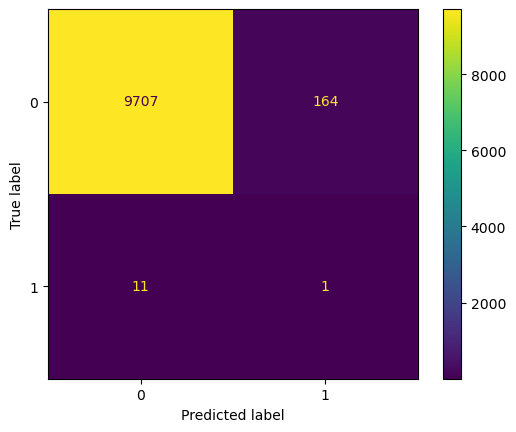

In [85]:
ConfusionMatrixDisplay.from_predictions(y_test,y_logreg_l2_pred)

In [128]:
print(f'Accuracy = {accuracy_score(y_test,y_logreg_l2_pred)} Recall = {recall_score(y_test,y_logreg_l2_pred)} Precision = {precision_score(y_test,y_logreg_l2_pred)} F1 Score = {f1_score(y_test,y_logreg_l2_pred)}')

Accuracy = 0.98229282606496 Recall = 0.08333333333333333 Precision = 0.006060606060606061 F1 Score = 0.01129943502824859


In [86]:
model_candidates.append(
    {
        'name':'Logistic Regression L2'
        ,'model':logreg_l2
        ,'X_test':X_test_scaled_poly
        ,'y_test':y_test
    })

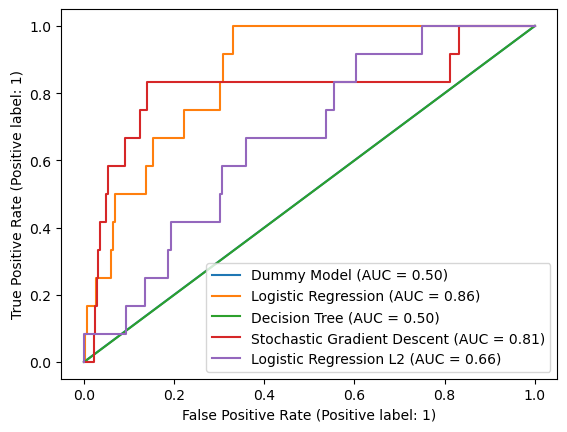

In [87]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [88]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test


y_df_logreg_l2_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_logreg_l2_pred['target'] = y_logreg_l2_pred


In [89]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_logreg_l2_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.021455687459131883


# Fifth Model - Logistic Regression with L1 Penalty

In [90]:
param2 = [{'C':[0.1,1,10]}]

In [91]:
pf = PolynomialFeatures(degree=2)
X_train_scaled_poly = pf.fit_transform(X_train_scaled)
X_test_scaled_poly = pf.transform(X_test_scaled)

In [92]:
logreg_pen2 = LogisticRegression(penalty='l1',solver='liblinear',random_state=19,class_weight='balanced',max_iter=10000)

grid_logreg_pen2 = GridSearchCV(logreg_pen2,param_grid=param2,scoring='recall',verbose=3, cv=2)

In [93]:
grid_logreg_pen2.fit(X_train_scaled_poly,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END .............................C=0.1;, score=0.083 total time=   5.5s
[CV 2/2] END .............................C=0.1;, score=0.083 total time=  11.6s
[CV 1/2] END ...............................C=1;, score=0.000 total time=  13.9s
[CV 2/2] END ...............................C=1;, score=0.083 total time=  10.0s
[CV 1/2] END ..............................C=10;, score=0.000 total time=   6.7s
[CV 2/2] END ..............................C=10;, score=0.000 total time=   5.6s


GridSearchCV(cv=2,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, penalty='l1',
                                          random_state=19, solver='liblinear'),
             param_grid=[{'C': [0.1, 1, 10]}], scoring='recall', verbose=3)

In [94]:
grid_logreg_pen2.best_params_

{'C': 0.1}

In [95]:
logreg_l1 = grid_logreg_pen2.best_estimator_

In [96]:
logreg_l1.fit(X_train_scaled_poly,y_train)
#Best model has C=0.1 

LogisticRegression(C=0.1, class_weight='balanced', max_iter=10000, penalty='l1',
                   random_state=19, solver='liblinear')

In [97]:
y_logreg_l1_pred = logreg_l1.predict(X_test_scaled_poly)

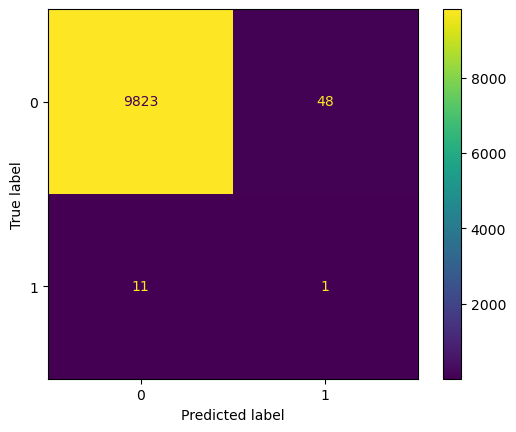

In [98]:
ConfusionMatrixDisplay.from_predictions(y_test,y_logreg_l1_pred)

In [129]:
print(f'Accuracy = {accuracy_score(y_test,y_logreg_l1_pred)} Recall = {recall_score(y_test,y_logreg_l1_pred)} Precision = {precision_score(y_test,y_logreg_l1_pred)} F1 Score = {f1_score(y_test,y_logreg_l1_pred)}')

Accuracy = 0.9940301527876151 Recall = 0.08333333333333333 Precision = 0.02040816326530612 F1 Score = 0.032786885245901634


In [99]:
model_candidates.append(
    {
        'name':'Logistic Regression L1'
        ,'model':logreg_l1
        ,'X_test':X_test_scaled_poly
        ,'y_test':y_test
    })

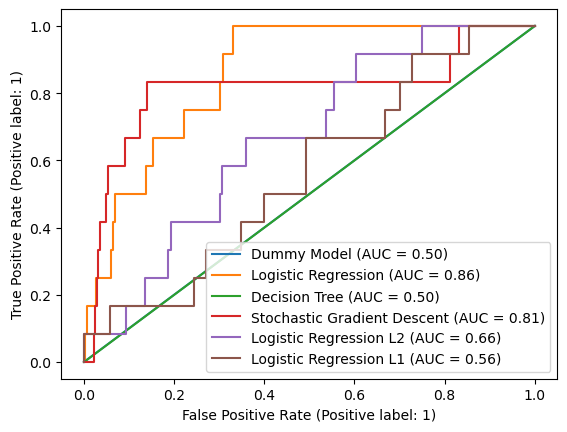

In [100]:
fig, ax = plt.subplots()

for model_candidate in model_candidates:
    RocCurveDisplay.from_estimator(model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    );

In [101]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test


y_df_logreg_l1_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_logreg_l1_pred['target'] = y_logreg_l1_pred


In [102]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_logreg_l1_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.021712085908215977


# Summary of results for analytic data

| Model | pAUC | 
| --- | --- |
| Dummy | 0.02 |
| Logistic regression | 0.035 |
| Decision Trees | 0.019 |
| Stochastic Gradient Descent | 0.098 |
| Logistic Regression L2 | 0.021 |
| Logistic Regression L1 | 0.022  |



The only models that performed significantly better than the Dummy Classifier were simple Logistic Regression and Stochastic Gradient Descent.

# Image analysis

Our first approach to this set is to first check the kind of pictures we are dealing with.

(145, 145, 3)

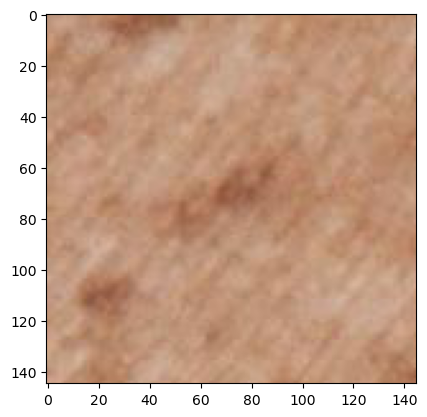

In [103]:
img=mpimg.imread('data/train-image/image/ISIC_2556571.jpg')
imgplot = plt.imshow(img)
img.shape

The images are in fact very low quality. We assemble the training and testing data. We use the indices to make sure those sets are the same than the ones we used before.

In [105]:
y_df_train = ID_tile_type.loc[pd.DataFrame(y_train).index].drop('tbp_tile_type',axis=1)
y_df_train['target'] = y_train

y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test

In [106]:
image_list_test = []
image_list_train = []

for id in list(y_df_test['isic_id']):
    filename = 'data/train-image/image/' + id + '.jpg'
    image_list_test.append(filename)

for id in list(y_df_train['isic_id']):
    filename = 'data/train-image/image/' + id + '.jpg'
    image_list_train.append(filename)

len(image_list_train),len(image_list_test)

(29647, 9883)

In [107]:
df_images_train = pd.DataFrame({'filename':image_list_train},index=y_df_train.index)
df_images_train['target'] = y_df_train['target']
df_images_train

,filename,target
393691,data/train-image/image/ISIC_9813959.jpg,0
21945,data/train-image/image/ISIC_0611494.jpg,0
353188,data/train-image/image/ISIC_8818850.jpg,0
122952,data/train-image/image/ISIC_3121602.jpg,0
22410,data/train-image/image/ISIC_0622602.jpg,0
...,...,...
56718,data/train-image/image/ISIC_1473708.jpg,0
179060,data/train-image/image/ISIC_4514088.jpg,0
3972,data/train-image/image/ISIC_0170260.jpg,0
228412,data/train-image/image/ISIC_5740722.jpg,0


In [108]:
df_images_test = pd.DataFrame({'filename':image_list_test},index=y_df_test.index)
df_images_test['target'] = y_df_test['target']
df_images_test

,filename,target
301942,data/train-image/image/ISIC_7551855.jpg,0
352194,data/train-image/image/ISIC_8794933.jpg,0
342922,data/train-image/image/ISIC_8566639.jpg,0
331403,data/train-image/image/ISIC_8284743.jpg,0
126724,data/train-image/image/ISIC_3212785.jpg,0
...,...,...
190586,data/train-image/image/ISIC_4798399.jpg,0
203127,data/train-image/image/ISIC_5111203.jpg,0
341897,data/train-image/image/ISIC_8542800.jpg,0
246276,data/train-image/image/ISIC_6187644.jpg,0


Finally we use ImageDataGenerator to convert each image to a format our Neural Network can accept. We also filter the images to grayscale so that our model can run faster and give us a first metric of its performance.

In [109]:
datagen = ImageDataGenerator(rescale=1./255)

generator_train = datagen.flow_from_dataframe(
    df_images_train,
    x_col='filename',
    y_col='target',
    color_mode="grayscale",
    target_size=(145, 145),  # Adjust to match your model's input size
    class_mode='raw',  # Change to 'binary' if you have binary classes
    shuffle=False
)

generator_test = datagen.flow_from_dataframe(
    df_images_test,
    x_col='filename',
    y_col='target',
    color_mode="grayscale",
    target_size=(145, 145),  # Adjust to match your model's input size
    class_mode='raw',  # Change to 'binary' if you have binary classes
    shuffle=False
)

Found 29647 validated image filenames.
Found 9883 validated image filenames.


# SkinLesNet

SkinLesNet is a Convolutional Neural Network developed by a research group in the UK that has perfomred much better than previous models. The paper can be found in this link https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10778045/pdf/cancers-16-00108.pdf .

We start by rebuilding the architecture of that neural network using tensorflow with our last node returning a probability of each instance being benign (target=0) or malign (target=1).

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(145, 145,1)))

model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       7

In [112]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=[tf.keras.metrics.Recall()])

In [113]:
history_cnn = model.fit(generator_train, epochs= 25, verbose = 2)

Epoch 1/25


2024-08-02 02:58:08.541813: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 83759104 exceeds 10% of free system memory.
2024-08-02 02:58:08.952899: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 83759104 exceeds 10% of free system memory.
2024-08-02 02:58:09.114693: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 83759104 exceeds 10% of free system memory.
2024-08-02 02:58:09.508123: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 83759104 exceeds 10% of free system memory.
2024-08-02 02:58:09.624235: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 83759104 exceeds 10% of free system memory.


927/927 - 398s - loss: 9.6503e-11 - recall: 0.2500
Epoch 2/25
927/927 - 389s - loss: 9.6503e-11 - recall: 0.1667
Epoch 3/25
927/927 - 390s - loss: 9.6503e-11 - recall: 0.2083
Epoch 4/25
927/927 - 396s - loss: 9.6503e-11 - recall: 0.2500
Epoch 5/25
927/927 - 391s - loss: 9.6503e-11 - recall: 0.2917
Epoch 6/25
927/927 - 439s - loss: 9.6503e-11 - recall: 0.2917
Epoch 7/25
927/927 - 462s - loss: 9.6503e-11 - recall: 0.1667
Epoch 8/25
927/927 - 430s - loss: 9.6503e-11 - recall: 0.1667
Epoch 9/25
927/927 - 535s - loss: 9.6503e-11 - recall: 0.2500
Epoch 10/25
927/927 - 490s - loss: 9.6503e-11 - recall: 0.2083
Epoch 11/25
927/927 - 436s - loss: 9.6503e-11 - recall: 0.2917
Epoch 12/25
927/927 - 430s - loss: 9.6503e-11 - recall: 0.3333
Epoch 13/25
927/927 - 465s - loss: 9.6503e-11 - recall: 0.3333
Epoch 14/25
927/927 - 469s - loss: 9.6503e-11 - recall: 0.2917
Epoch 15/25
927/927 - 448s - loss: 9.6503e-11 - recall: 0.3750
Epoch 16/25
927/927 - 433s - loss: 9.6503e-11 - recall: 0.2500
Epoch 17/25


In [121]:
y_cnn_pred_prob = model.predict(generator_test)

In [173]:
y_cnn_pred = np.where(y_cnn_pred_prob > 0.494, 1, 0)

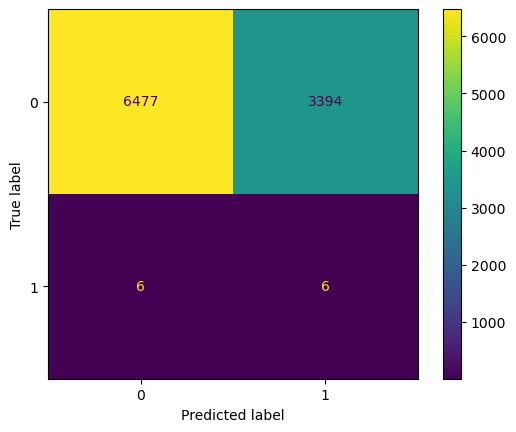

In [174]:
ConfusionMatrixDisplay.from_predictions(y_test,y_cnn_pred)

In [175]:
print(f'Accuracy = {accuracy_score(y_test,y_cnn_pred)} Recall = {recall_score(y_test,y_cnn_pred)} Precision = {precision_score(y_test,y_cnn_pred)} F1 Score = {f1_score(y_test,y_cnn_pred)}')

Accuracy = 0.6559749064049377 Recall = 0.5 Precision = 0.0017647058823529412 F1 Score = 0.003516998827667058


In [176]:
# pd.DataFrame(y_test)
y_df_test = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_test['target'] = y_test


y_df_cnn_pred = ID_tile_type.loc[pd.DataFrame(y_test).index].drop('tbp_tile_type',axis=1)
y_df_cnn_pred['target'] = y_cnn_pred


In [177]:
print(f'pAUC ROC = {pAUC_score(y_df_test,y_df_cnn_pred,row_id_column_name="isic_id")}')

pAUC ROC = 0.026246580893526477


| Model | pAUC | 
| --- | --- |
| CNN | 0.026 |

The CNN did not perform very well for our data. However, we used grayscaled pictures, with a different end node, with less epoches and with an extremely unbalanced dataset. We should run this again later with more data and time to see its real performance.

# Results

Our best models were (in decreasing order of importance):
| Model | pAUC | 
| --- | --- |
| Stochastic Gradient Descent | 0.098|
| Logistic Regression | 0.035|
| CNN | 0.026 |

This means that clinical patient data and measurements of lesion are still the best predictor if the lesion can be benign or not.

# Next steps

Four our next steps we have several recommendations:
- Add regularization to current CNN or use the original SkinLesNet model to test its true potential. Play with prediction thresholds;
- We only used one CNN architecture but others have been reported and we can fit them and see if our metrics become better. Employ Voting Classifier  and Pipelines.
- Try using GPU, clusters or a new computer to process data. This would require an investment to our current business.